<a href="https://colab.research.google.com/github/tinycar2008/cnn-detect-pet-emotions/blob/main/20241111_Assignment_10_Pet_Emotions_V4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment: Pet Emotions Model

In this assignment, build a model to help recognize emotions of pets from their facial expressions, gain insights into pet emotions and personalities, create fun and creative projects with pet face images, and contribute to pet face recognition research and animal welfare. This can help pet owners understand their pets better and improve their well-being.

1. Use ResNet50 as basemodel
2. Build hidden layers with more ResNet layers.
3. Train data, using early stopping.

* Adjusted several times the layers. And I noticed that the flatten layers need to be big for the gradient to start converging.

* Additionally, augmented images did this algorithm no favour to pick up on the small differences.

* Me merging sum of the data in the arrays might have mixed up the labels.

**Second trial:**

* FINAL confusion matrix: 64 dense layer, dropout = 0.25
* Best approach was  not to augment images
* Use ResNet model, add final layers yourself.

## 1. Loading the data

In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import imghdr
from tensorflow.keras import layers, models, regularizers, optimizers
from tensorflow.keras.applications import VGG16, ResNet50V2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, Adamax
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.utils import plot_model
import seaborn as sns

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("anshtanwar/pets-facial-expression-dataset")

print("Path to dataset files:", path)

100%|██████████| 38.6M/38.6M [00:02<00:00, 14.0MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/anshtanwar/pets-facial-expression-dataset/versions/11


In [ ]:
import os

dataset_path = '/root/.cache/kagglehub/datasets/anshtanwar/pets-facial-expression-dataset/versions/11'

for root, dirs, files in os.walk(dataset_path):
    for dir_name in dirs:
        subfolder_path = os.path.join(root, dir_name)
        print(f"Subfolder: {subfolder_path}")
        # You can further explore files within each subfolder here
        # for file_name in files:
        #     file_path = os.path.join(root, file_name)
        #     print(f"  File: {file_path}")

Subfolder: /root/.cache/kagglehub/datasets/anshtanwar/pets-facial-expression-dataset/versions/11/Other
Subfolder: /root/.cache/kagglehub/datasets/anshtanwar/pets-facial-expression-dataset/versions/11/Master Folder
Subfolder: /root/.cache/kagglehub/datasets/anshtanwar/pets-facial-expression-dataset/versions/11/happy
Subfolder: /root/.cache/kagglehub/datasets/anshtanwar/pets-facial-expression-dataset/versions/11/Angry
Subfolder: /root/.cache/kagglehub/datasets/anshtanwar/pets-facial-expression-dataset/versions/11/Sad
Subfolder: /root/.cache/kagglehub/datasets/anshtanwar/pets-facial-expression-dataset/versions/11/Master Folder/valid
Subfolder: /root/.cache/kagglehub/datasets/anshtanwar/pets-facial-expression-dataset/versions/11/Master Folder/train
Subfolder: /root/.cache/kagglehub/datasets/anshtanwar/pets-facial-expression-dataset/versions/11/Master Folder/test
Subfolder: /root/.cache/kagglehub/datasets/anshtanwar/pets-facial-expression-dataset/versions/11/Master Folder/valid/Other
Subfol

In [ ]:
angry='/root/.cache/kagglehub/datasets/anshtanwar/pets-facial-expression-dataset/versions/11/Angry'
sad='/root/.cache/kagglehub/datasets/anshtanwar/pets-facial-expression-dataset/versions/11/Sad'
happy='/root/.cache/kagglehub/datasets/anshtanwar/pets-facial-expression-dataset/versions/11/happy'

image_exts = ['jpeg', 'jpg', 'png']
def images(folder):
    images=[]
    for file in os.listdir(folder):
        img=(os.path.join(folder,file))
        if((imghdr.what(img) in image_exts)):
            img=cv2.imread(img,cv2.COLOR_BGR2GRAY)
            img=cv2.resize(img,(224,224))
            images.append(img)
    return images
angry_img=images(angry)
happy_img=images(happy)
sad_img=images(sad)

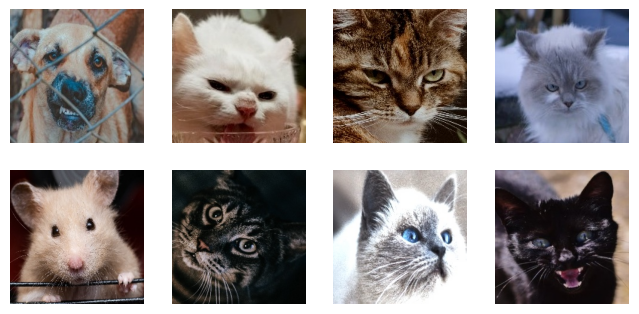

In [ ]:
plt.figure(figsize=(8,8))
for i, file in enumerate(os.listdir(angry),1):
  img = os.path.join(angry, file)
  img = plt.imread(img)
  plt.subplot(4, 4, i)
  plt.imshow(img)
  plt.axis('off')
  if(i==8):
    break

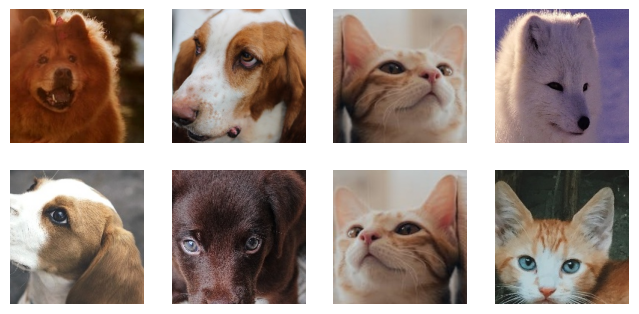

In [ ]:
plt.figure(figsize=(8,8))
for i, file in enumerate(os.listdir(sad),1):
  img = os.path.join(sad, file)
  img = plt.imread(img)
  plt.subplot(4, 4, i)
  plt.imshow(img)
  plt.axis('off')
  if(i==8):
    break

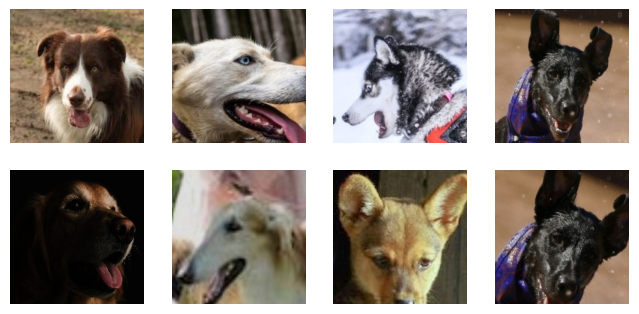

In [ ]:
plt.figure(figsize=(8,8))
for i, file in enumerate(os.listdir(happy),1):
  img = os.path.join(happy, file)
  img = plt.imread(img)
  plt.subplot(4, 4, i)
  plt.imshow(img)
  plt.axis('off')
  if(i==8):
    break

In [ ]:
#Creating labels for each category

angry_labels = [0] * len(angry_img)
happy_labels = [1] * len(happy_img)
sad_labels = [2] * len(sad_img)

X = np.array(angry_img+happy_img+sad_img)
y = np.array(angry_labels + happy_labels + sad_labels)
X = X.astype('float32') / 255.0

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [ ]:
from keras.utils import to_categorical
y_train_onehot = to_categorical(y_train, num_classes=3)
y_val_onehot = to_categorical(y_val, num_classes=3)

In [ ]:
Basemodel = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

In [ ]:
Basemodel.trainable = True

for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [ ]:
def Create_model():
    model = Sequential([
        Basemodel,
        GlobalAveragePooling2D(),
        Dropout(0.25),
        BatchNormalization(),
        Dense(128, activation='relu'),
        Dropout(0.25),
        BatchNormalization(),
        #Dense(512, activation='relu'),#reversing to larger dense layer
        Dense(64, activation='relu'),
        Dropout(0.25),
        BatchNormalization(),
        Dense(3, activation='softmax')
    ])
    return model

In [ ]:
model = Create_model()
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)              │ (None, 7, 7, 2048)          │      23,564,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_6           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 128)                 │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 64)                  │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,844,483 (90.96 MB)

 Trainable params: 23,794,563 (90.77 MB)

 Non-trainable params: 49,920 (195.00 KB)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

earlystop = EarlyStopping(monitor='val_loss', patience=10, min_delta=0.001, verbose=1, restore_best_weights=True)

In [ ]:
history = model.fit(
    X_train, y_train_onehot,
    validation_data=(X_val, y_val_onehot),
    epochs=60,
    batch_size=32,
    callbacks=[earlystop]
)

Epoch 1/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 51s 387ms/step - accuracy: 0.3750 - loss: 1.4147 - val_accuracy: 0.3667 - val_loss: 83.8182
Epoch 2/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.4640 - loss: 1.2276 - val_accuracy: 0.3917 - val_loss: 61.7891
Epoch 3/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4155 - loss: 1.3131 - val_accuracy: 0.2667 - val_loss: 183.5116
Epoch 4/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4166 - loss: 1.2098 - val_accuracy: 0.2917 - val_loss: 109.1607
Epoch 5/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.4383 - loss: 1.2157 - val_accuracy: 0.3250 - val_loss: 117.0866
Epoch 6/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.4419 - loss: 1.1471 - val_accuracy: 0.3000 - val_loss: 33.2040
Epoch 7/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5254 - loss: 1.0744 - val_accuracy: 0.2583 - val_loss: 38.1805
Epoch 8/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5263 - loss: 1.0058 - val_accuracy

In [ ]:
# 2. Epoch 16 best with dropout = 0.25

Epoch 16/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - accuracy: 0.8475 - loss: 0.4252 - val_accuracy: 0.4250 - val_loss: 1.3069

# 3. Smaller Dense layer of 64

Epoch 2/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - accuracy: 0.6551 - loss: 0.8084 - val_accuracy: 0.5417 - val_loss: 1.1010
Epoch 3/60

# 4. Made drop out smaller again and increase dense layer again

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9400 - loss: 0.1749 - val_accuracy: 0.4083 - val_loss: 3.2472

# 5. Changed dropout to 0.3 and kept dense layer (512)

15/15 ━━━━━━━━━━━━━━━━━━━━ 52s 383ms/step - accuracy: 0.4477 - loss: 1.3731 - val_accuracy: 0.2667 - val_loss: 1.2538

## 6. Changed dropout to 0.25 and added 64 dense layer

Epoch 26/60
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9465 - loss: 0.2158 - val_accuracy: 0.5333 - val_loss: 1.1142
Epoch 27/60


In [ ]:
#Function to plot training history

def plot_training_history(history):
  #Plot accuracy and loss
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  epochs = range(len(acc))
  plt.figure(figsize=(15,5))
  plt.subplot(1,2,1)
  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend(loc='lower right')
  plt.subplot(1,2,2)
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend(loc='upper right')
  plt.show()

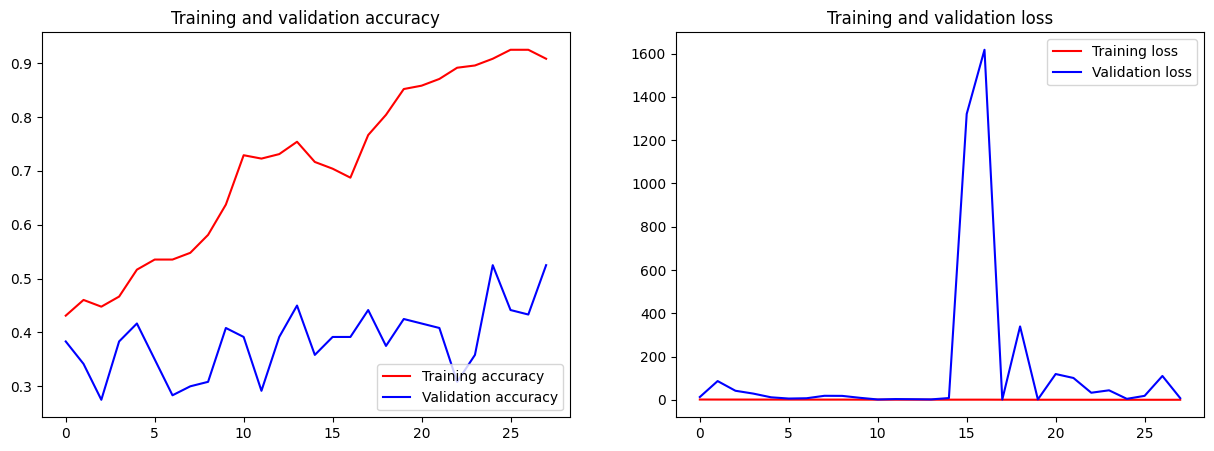

In [ ]:
plot_training_history(history) #before changing dropout

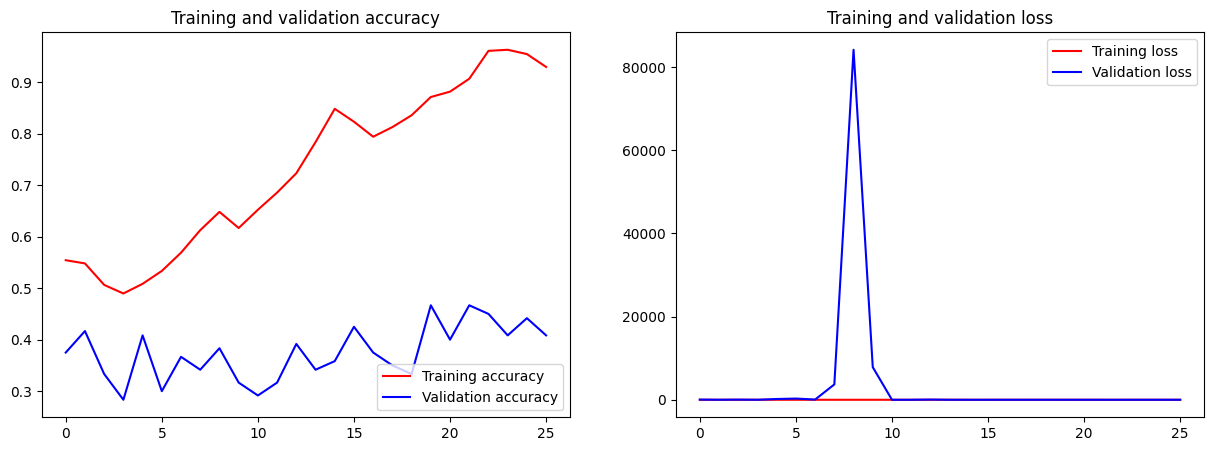

In [ ]:
plot_training_history(history) #after changing dropout

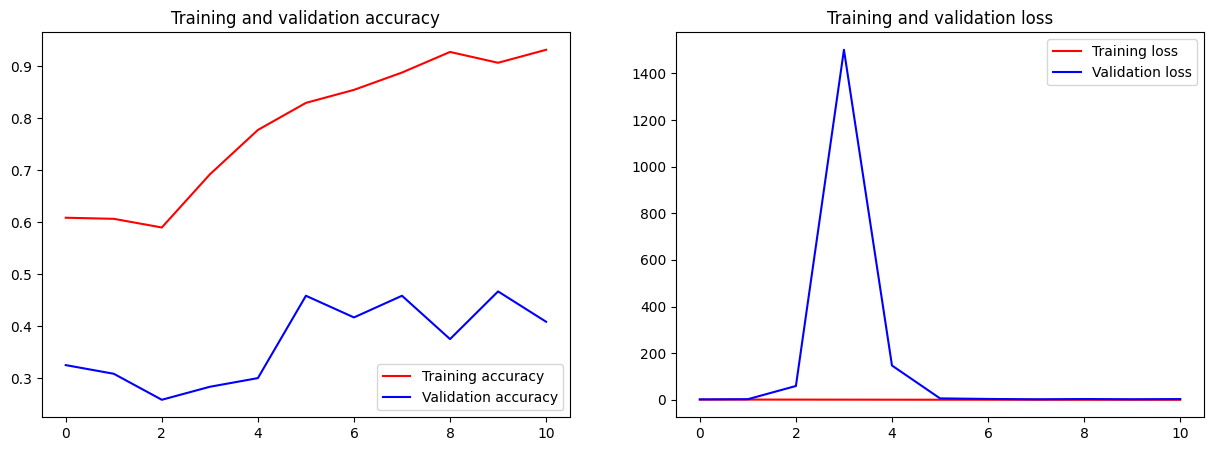

In [ ]:
plot_training_history(history) #reversing setting from the start

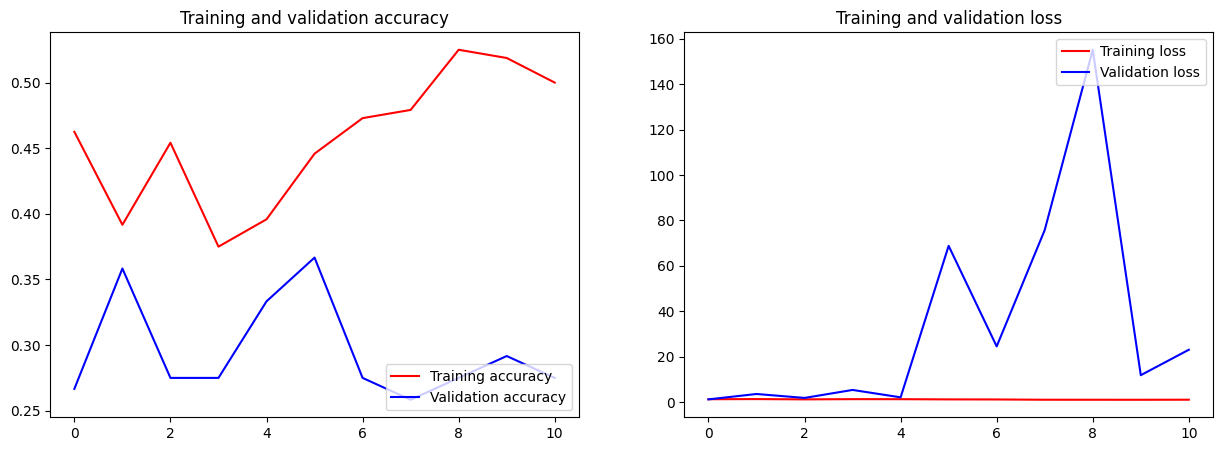

In [ ]:
plot_training_history(history) #increase dropout to 0.3 and dense layer 512

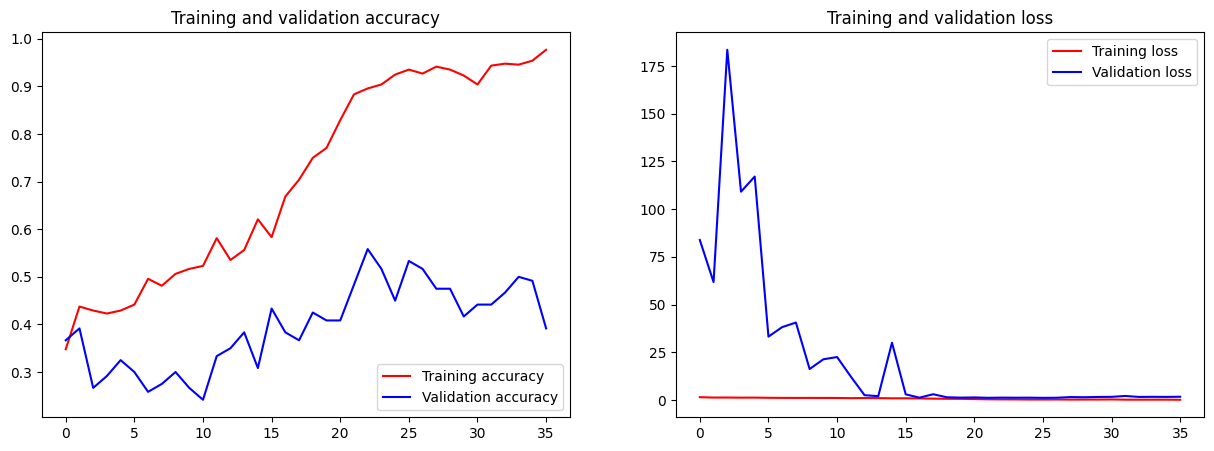

In [ ]:
##FINAL RESULT: Changed dropout to 0.25 and added 64 dense layer

#Epoch 26/60
#15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - accuracy: 0.9465 - loss: 0.2158 - val_accuracy: 0.5333 - val_loss: 1.1142


plot_training_history(history)

5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 1s/step


Text(0.5, 1.0, 'Confusion Matrix')

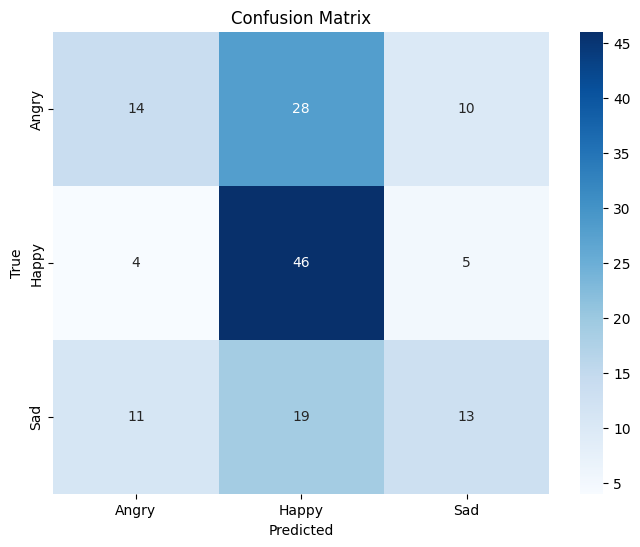

In [ ]:
#Confusion matrix before changing dropout

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Angry', 'Happy', 'Sad'], yticklabels=['Angry', 'Happy', 'Sad'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 949ms/step


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

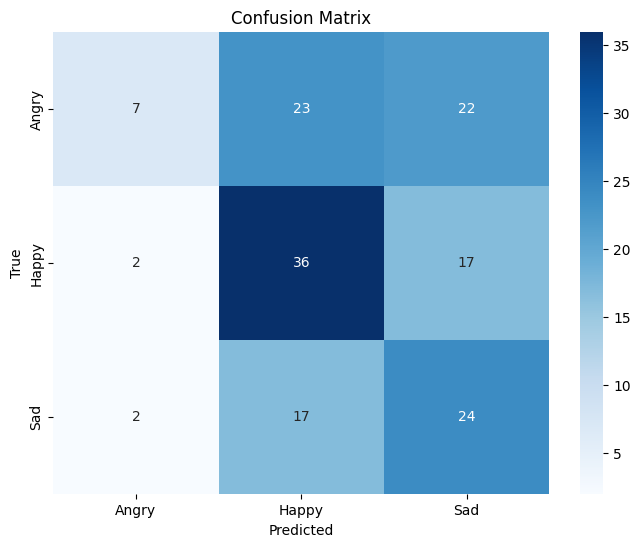

In [ ]:
# Confusion matrix after changing dropout to 0.25

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Angry', 'Happy', 'Sad'], yticklabels=['Angry', 'Happy', 'Sad'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt

1/5 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 686ms/step


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

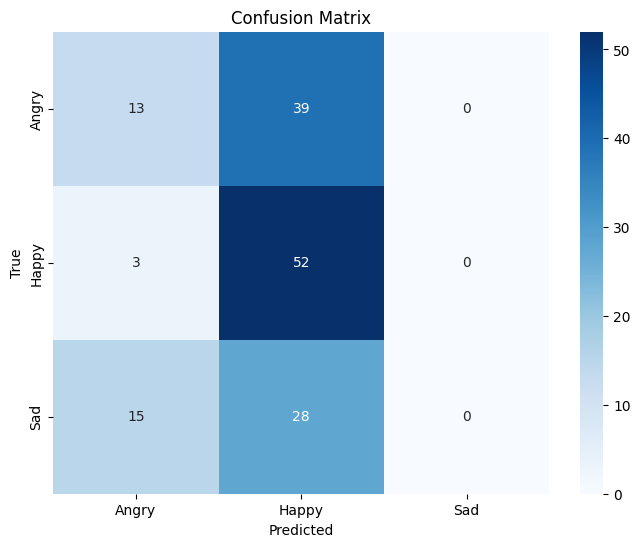

In [ ]:
# Reversing to the setting from the start

# Confusion matrix after changing dropout

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Angry', 'Happy', 'Sad'], yticklabels=['Angry', 'Happy', 'Sad'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt

5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 759ms/step


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

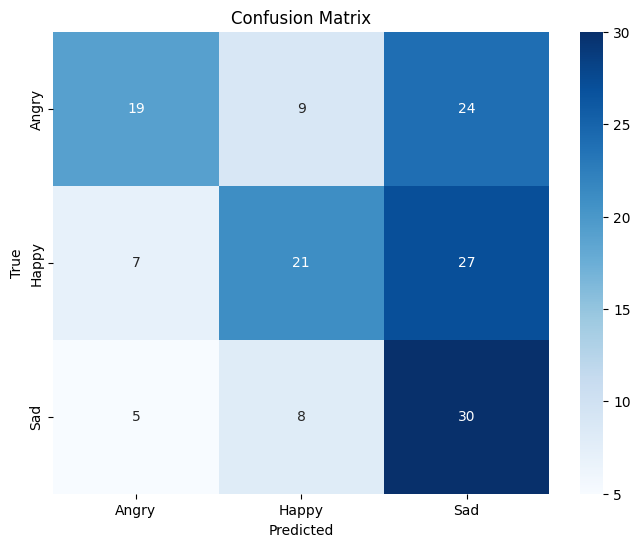

In [ ]:
# FINAL confusion matrix: 64 dense layer, dropout = 0.25

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Angry', 'Happy', 'Sad'], yticklabels=['Angry', 'Happy', 'Sad'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt